<a href="https://colab.research.google.com/github/maritverboom/TM10007_PROJECT/blob/master/assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TM10007 Assignment Group 15
Bart Formsma: 

Eline van Lange: 

Laurien Reinders:

Marit Verboom: 4453778


In [41]:
# Run this to use from colab environment
!pip install -q --upgrade git+https://github.com/karinvangarderen/tm10007_project.git

In [0]:
# General packages
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd
from sklearn import metrics
import seaborn as sns

# Feature selection
from sklearn import feature_selection
# Univariate
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import SelectPercentile
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import GenericUnivariateSelect

# Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import Lasso
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from yellowbrick.regressor import AlphaSelection
from yellowbrick.datasets import load_concrete
from sklearn.feature_selection import SelectFromModel

# Classifiers
from sklearn import model_selection
from sklearn import preprocessing
from sklearn import neighbors
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier

# Statistics
from statistics import mean
from sklearn.metrics import confusion_matrix

## Data Loading
- Loading the provided Head & Neck dataset
- Splitting the data in train- and testset
- Binarizing tumor stages: TM12 = 0, TM34 = 1


In [48]:
#Import dataset
from hn.load_data import load_data
data = load_data()
data_start = data
print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

# Splitting the data in train- and testpart with a portion of 'test_size' testing data (20%)
data_train, data_test = model_selection.train_test_split(data, test_size=0.20, stratify=data['label'])

print(f'The number of rows of train data : {len(data_train.index)}')
print(f'The number of rows of test data : {len(data_test.index)}')

# dataframe containing tumor stadium of subject (T12/T34)
stage_train = data_train['label']             
stage_test = data_test['label'] 

# dataframe containing all feature columns except 'label' (tumor stadium of subject)
data_train = data_train.drop(columns='label') 
data_test = data_test.drop(columns='label')

# Binarize label data
stage_train = preprocessing.label_binarize(stage_train, ['T12', 'T34'])
stage_train = [i[0] for i in stage_train]
stage_test = preprocessing.label_binarize(stage_test, ['T12', 'T34'])
stage_test = [i[0] for i in stage_test]

print(stage_train)




The number of samples: 113
The number of columns: 160
The number of rows of train data : 90
The number of rows of test data : 23
[0, 0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1]


## Data cleaning
- Removing columns where > 25% of the values are 0.0
- Removing columns whit a constant value


In [49]:
def data_cleaning(data_train, data_test):
    """
    Feature for cleaning the data.
    """
    # Remove all columns where more than 25% of the values are 0.0
    drop_cols_train = data_train.columns[(data_train == 0).sum() > 0.25*data_train.shape[1]]
    drop_cols_test = data_test.columns[(data_train ==0).sum() > 0.25*data_train.shape[1]]
    data_train.drop(drop_cols_train, axis = 1, inplace = True) 
    data_test.drop(drop_cols_test, axis = 1, inplace = True)
    
    # Remove all columns with no std
    drop_std_train = data_train.columns[data_train.std() == 0]
    drop_std_test = data_test.columns[data_train.std() == 0]
    data_train.drop(drop_std_train, axis = 1, inplace = True) 
    data_test.drop(drop_std_test, axis = 1, inplace = True)
    
    return data_train, data_test

data_train, data_test = data_cleaning(data_train, data_test)

print(f'TRAIN: The number of columns after preprocessing: {len(data_train.columns)}, and the number of rows: {len(data_train.index)}')
print(f'TEST: The number of columns after preprocessing: {len(data_test.columns)},  and the number of rows: {len(data_test.index)}')


TRAIN: The number of columns after preprocessing: 150, and the number of rows: 90
TEST: The number of columns after preprocessing: 150,  and the number of rows: 23


## Data Scaling

- Scaling the train- and test dataset with a Standard Scaler
 

In [0]:
def data_scaling(data_train, data_test):
    """
    Function to scale the data using a StandardScaler.
    """
    # Scale the data (train on train set)
    scaler = preprocessing.StandardScaler()   
    scaler.fit(data_train)  

    # Perform scaling on both train and testset, returing scaled dataframe
    data_train_scaled = pd.DataFrame(scaler.transform(data_train), columns = data_train.columns)
    data_test_scaled = pd.DataFrame(scaler.transform(data_test), columns=data_test.columns) 

    return data_train_scaled, data_test_scaled

data_train_scaled, data_test_scaled = data_scaling(data_train, data_test)


## Preprocessing: Feature selection/extraction

- Recursive Feature Elimination
- Univariate Feature Selection
- Principal Component Analysis
- L1/Lasso Regression Feature Selection

## Recursive Feature Elimination

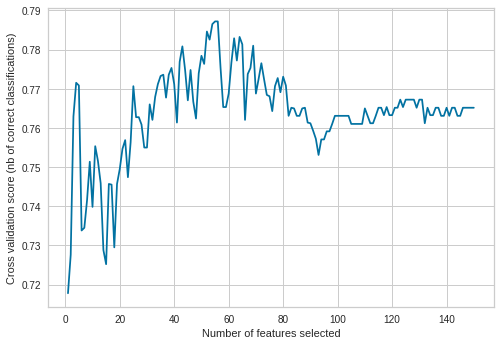

Num Features: 55
Selected Features: [ True False False  True False False  True  True  True  True  True  True
 False False False False  True False False False False  True  True  True
  True  True False False  True False False False  True  True False  True
 False False False  True  True False  True False False False False False
 False False  True  True False False False False False  True False False
 False False False False False  True False False False False False False
 False False  True False False False False  True  True  True False  True
  True False False  True  True False False False  True  True False False
  True False False False  True  True  True False False False False False
 False  True False False False  True False  True  True  True False False
  True  True False  True  True False False False  True  True False False
  True  True  True False False False False False  True False  True False
 False False False False False False]
Feature Ranking: [ 1 21 11  1 95 86  1  1  1  1  1

In [51]:
# Create the RFE object
svc = svm.SVC(kernel="linear")  

# classifications
rfecv = feature_selection.RFECV(
    estimator=svc, step=1, 
    cv=model_selection.StratifiedKFold(4),
    scoring='roc_auc')
fit_rfecv = rfecv.fit(data_train_scaled, stage_train)

# Plot number of features VS. cross-validation scores
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(rfecv.grid_scores_) + 1), rfecv.grid_scores_)
plt.show()

print("Num Features: %d" % fit_rfecv.n_features_)
print("Selected Features: %s" % fit_rfecv.support_)
print("Feature Ranking: %s" % fit_rfecv.ranking_)

data_train_rfecv = rfecv.transform(data_train_scaled)
data_test_rfecv = rfecv.transform(data_test_scaled)

print(data_train_rfecv.shape)
print(data_test_rfecv.shape)

##  Feature selection using univariate feature selection

In [54]:
# Eventuele hyperparameters die nog kunnen worden aangepast: methodes voor univariate feature selection (selectKBest, SelectPercentile, en nog meer),
# measures om 'best' te bepalen chi2, f_classif, mutual_info_classif
# aantal features dat je selecteert, getal voor percentile, getal voor k-best, etc.
# Moeilijk om deze hyperparameters te tunen aangezien de performance pas wordt bepaald bij het toepassen van de classifier, zal waarschijnlijk ook verschillen per classifier.
# 
# Bij het opnieuw splitten van de data in een train en test set zie je dat er een andere set aan features geselecteerd wordt, zijn overeenkomsten maar je ziet ook verschillen. Zeer waarschijnlijk leidt dit uiteindelijk tot een hogere variantie in performance bij het nemen van een nieuwe split mbv cross validatie checken.

def uni_features(data_train, data_test, stage_train):
    """
    Function to perform univariate feature selection
    """
    # Apply SelectPercentile to train data to extract top 20% best features according to train data
    selector_uni = SelectPercentile(f_classif, percentile=20)
    selector_uni.fit(data_train, stage_train)
    data_train_uni = selector_uni.transform(data_train)
    data_test_uni = selector_uni.transform(data_test)

    return data_train_uni, data_test_uni

data_train_uni, data_test_uni = uni_features(data_train, data_test, stage_train)

# Visualisation of the selected best 20% features
dfscores = pd.DataFrame(fit_uni.scores_)
dfcolumns = pd.DataFrame(data_train.columns)

# Concat two dataframes for better visualization 
featureScores = pd.concat([dfcolumns,dfscores],axis=1)

featureScores.columns = ['Specs','Score']  #naming the dataframe columns
# Print dataframe
print(featureScores.nlargest(int(0.2*len(featureScores)),'Score'))  #print 40 best features



print(data_train_uni.shape)
print(data_test_uni.shape)

                                         Specs      Score
39                         tf_GLRLM_RunEntropy  46.394733
42                      tf_GLRLM_RunPercentage  35.699339
25                          sf_rad_dist_avg_2D  30.711383
41   tf_GLRLM_RunLengthNonUniformityNormalized  29.472809
40             tf_GLRLM_RunLengthNonUniformity  28.913205
32             tf_GLRLM_GrayLevelNonUniformity  26.830719
0                                    hf_energy  26.218357
43                        tf_GLRLM_RunVariance  23.252517
128                       tf_Gabor_0.5A2.36max  23.005169
1                                   hf_entropy  21.873450
121                      tf_Gabor_0.5A1.57kurt  21.672345
44                   tf_GLRLM_ShortRunEmphasis  20.109147
131                      tf_Gabor_0.5A2.36skew  19.143041
125                      tf_Gabor_0.5A1.57skew  18.975188
134                     tf_LBP_kurtosis_R3_P12  18.673590
130                       tf_Gabor_0.5A2.36min  17.940010
46       tf_GL

## Principal Component Analysis (PCA)


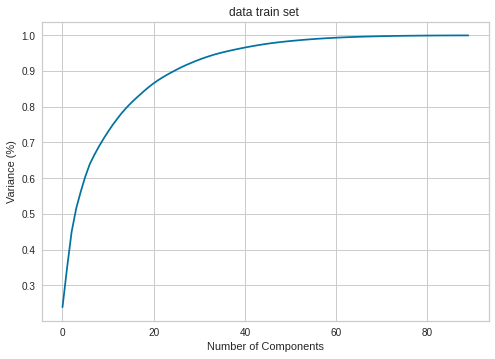

(90, 56)
(23, 56)


In [55]:

# Create a function for calculating PCA
def pca(data_train, data_test):
    """
    Function for PCA

        data_train = training data
        data_test = testing data

    Output is transformed train- and testdata
    """
    pca=PCA().fit(data_train)
    var = np.cumsum(pca.explained_variance_ratio_)
    n_comp = np.where(var>0.99)[0][0]

    pca_train = PCA(n_components=n_comp)
    pca_train.fit(data_train)

    # Transform data using PCA
    data_train_trans = pca_train.transform(data_train)
    data_test_trans = pca_train.transform(data_test)
    
    plt.figure()
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Number of Components')
    plt.ylabel('Variance (%)') # for each component
    plt.title('data train set ')
    plt.show()
#print(np.cumsum(pca.explained_variance_ratio_))

    # Return transformed train- and testdata
    return data_train_trans, data_test_trans

data_train_pca, data_test_pca = pca(data_train_scaled, data_test_scaled)
print(data_train_pca.shape)
print(data_test_pca.shape)



## Lasso feature selection


The optimal alpha = 0.060451493537854416
Selected 9 from 150 features.


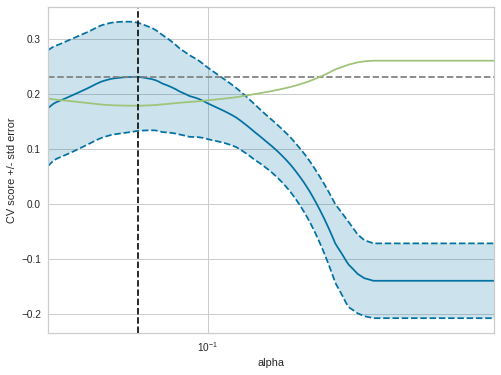

In [56]:
lasso = Lasso(max_iter=10000)
n_alphas = 200
alphas = np.logspace(-1.5, -0.1, n_alphas)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(lasso, tuned_parameters, cv=n_folds, refit=False)
clf.fit(data_train_scaled, stage_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# Instantiate the linear model and visualizer
model = LassoCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(data_train_scaled, stage_train)
#visualizer.show()

alpha_best = model.alpha_
print(f'The optimal alpha = {alpha_best}')

#L1_selection = Lasso(alpha=alpha_best, max_iter=10000)
#L1_selection.fit(data_train_scaled, stage_train)
#train_score=L1_selection.score(data_train_scaled,stage_train)
#coeff_used = np.sum(L1_selection.coef_!=0)
#print("training score:", train_score) 
#print("number of features used: ", coeff_used)

selector = SelectFromModel(estimator=Lasso(alpha=alpha_best, random_state = 42))
selector.fit(data_train_scaled, stage_train)
n_original = data_train_scaled.shape[1]
data_train_l1 = selector.transform(data_train_scaled)
data_test_l1 = selector.transform(data_test_scaled)
n_selected = data_train_l1.shape[1]
print(f"Selected {n_selected} from {n_original} features.")



# L2/ridge classifier

In [0]:
ridge = RidgeClassifier(max_iter=10000)
n_alphas = 200
alphas = np.logspace(-1.5, -0.1, n_alphas)

tuned_parameters = [{'alpha': alphas}]
n_folds = 5

clf = GridSearchCV(ridge, tuned_parameters, cv=n_folds, refit=False)
clf.fit(data_train_scaled, stage_train)
scores = clf.cv_results_['mean_test_score']
scores_std = clf.cv_results_['std_test_score']
plt.figure().set_size_inches(8, 6)
plt.semilogx(alphas, scores)

# plot error lines showing +/- std. errors of the scores
std_error = scores_std / np.sqrt(n_folds)

plt.semilogx(alphas, scores + std_error, 'b--')
plt.semilogx(alphas, scores - std_error, 'b--')

# alpha=0.2 controls the translucency of the fill color
plt.fill_between(alphas, scores + std_error, scores - std_error, alpha=0.2)

plt.ylabel('CV score +/- std error')
plt.xlabel('alpha')
plt.axhline(np.max(scores), linestyle='--', color='.5')
plt.xlim([alphas[0], alphas[-1]])

# Instantiate the linear model and visualizer
model = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(model)
visualizer.fit(data_train_scaled, stage_train)
#visualizer.show()

alpha_best = model.alpha_
print(f'The optimal alpha = {alpha_best}')

#L1_selection = Ridge(alpha=alpha_best, max_iter=10000)
#L1_selection.fit(data_train_scaled, stage_train)
#train_score=L1_selection.score(data_train_scaled,stage_train)
#coeff_used = np.sum(L1_selection.coef_!=0)
#print("training score:", train_score) 
#print("number of features used: ", coeff_used)

selector = SelectFromModel(estimator=Ridge(alpha=alpha_best, random_state = 42))
selector.fit(data_train_scaled, stage_train)
n_original = data_train_scaled.shape[1]
data_train_l1 = selector.transform(data_train_scaled)
data_test_l1 = selector.transform(data_test_scaled)
n_selected = data_train_l1.shape[1]
print(f"Selected {n_selected} from {n_original} features.")

NameError: ignored

## kNN 

The train accuracy of a kNN x classifier with x feature selection: 0.9027777777777778
The validation accuracy of a kNN x classifier with x feature selection: 0.6833333333333333
The AUC of validation data: 0.6975874125874126
The sensitivity of validation data: 0.6666666666666666
The specificity of validation data: 0.7
The train accuracy of a kNN x classifier with x feature selection: 0.8319444444444445
The validation accuracy of a kNN x classifier with x feature selection: 0.6444444444444445
The AUC of validation data: 0.6609250471750472
The sensitivity of validation data: 0.6888888888888889
The specificity of validation data: 0.6
The train accuracy of a kNN x classifier with x feature selection: 0.7805555555555556
The validation accuracy of a kNN x classifier with x feature selection: 0.6555555555555556
The AUC of validation data: 0.694866452991453
The sensitivity of validation data: 0.5444444444444444
The specificity of validation data: 0.7666666666666666


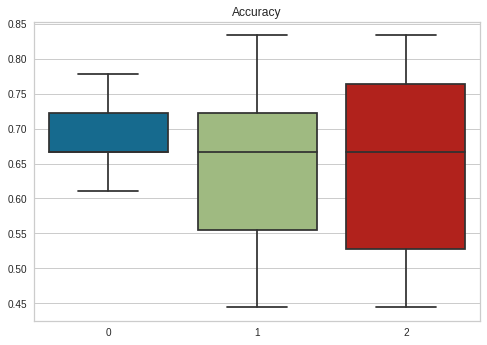

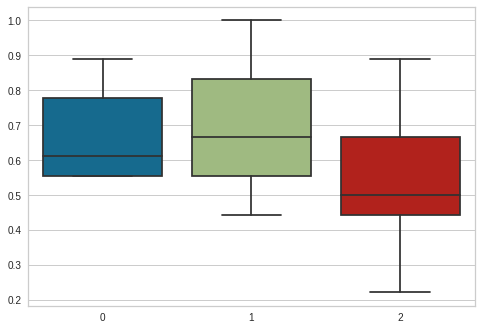

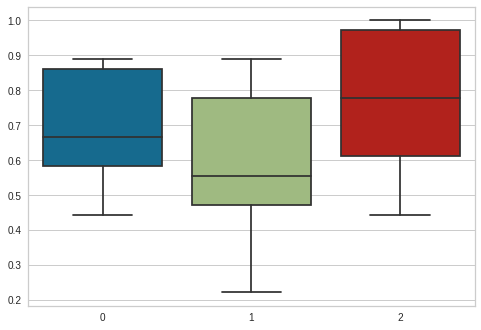

In [57]:
def knn_classifier(leaf_size, p, n_neigbors, weights, data_train, data_test, label_train, label_test):
  
    """
    Function for kNN training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    knn = neighbors.KNeighborsClassifier(n_neighbors = n_neigbors)
    knn.fit(data_train, label_train)
    label_train_knn = knn.predict(data_train)
    label_test_knn = knn.predict(data_test)
    score_train = knn.score(data_train, label_train)
    score_test = knn.score(data_test, label_test)
    return score_train, score_test, label_train_knn, label_test_knn

# Hyperparameters optimization 
leaf_size = list(range(1,50))
n_n = list(range(1,50))
p=[1,2]
weights = ['uniform', 'distance']

hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_n, p=p, weights = weights)
knn_tune = neighbors.KNeighborsClassifier()
clf_tune_knn = model_selection.RandomizedSearchCV(knn_tune, hyperparameters, n_iter = 30, cv=5)

 # 10 keer opnieuw train-val   
sss = model_selection.StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=42)

score_train_lasso = []
score_val_lasso = []
score_train_uni = []
score_val_uni = []
score_train_pca = []
score_val_pca = []

selectorlasso = SelectFromModel(estimator=Lasso(alpha=0.067, random_state = 42))
selectoruni = SelectPercentile(f_classif, percentile=20)
selectorpca = PCA(n_components = 20)
selectors = [selectorlasso, selectoruni, selectorpca]

score_train_box = []
score_val_box = []
sens_val_box = []
spec_val_box = []

for selector in selectors: 
    score_train_selector = []
    score_val_selector = []
    sens_val_selector = []
    spec_val_selector = []
    auc_val_selector = []
    for train_index, val_index in sss.split(data_train_scaled, stage_train):
        stage_train_k = np.array(stage_train)  

        split_X_train = data_train_scaled.loc[train_index]
        split_y_train = stage_train_k[train_index]
        split_X_val = data_train_scaled.loc[val_index]
        split_y_val = stage_train_k[val_index]

        selector.fit(split_X_train, split_y_train)
        split_X_train = selector.transform(split_X_train)
        split_X_val = selector.transform(split_X_val)

        best_model = clf_tune_knn.fit(split_X_train, split_y_train)
        leaf_size_best = best_model.best_estimator_.get_params()['leaf_size']
        p_best = best_model.best_estimator_.get_params()['p']
        n_n_best = best_model.best_estimator_.get_params()['n_neighbors']
        weights_best = best_model.best_estimator_.get_params()['weights']
   
        score_train, score_val, label_train, label_val = knn_classifier(leaf_size_best, 
                        p_best, n_n_best, weights_best, split_X_train, split_X_val, split_y_train, split_y_val)
        
        conf = confusion_matrix(split_y_val, label_val)
        sens_val = conf[0, 0]/(conf[0, 0]+conf[0, 1])
        spec_val = conf[1, 1]/(conf[1, 0]+conf[1, 1])
        
        auc_val=metrics.roc_auc_score(label_val, split_y_val)

        score_train_selector.append(score_train)
        score_val_selector.append(score_val)   
        sens_val_selector.append(sens_val)
        spec_val_selector.append(spec_val)
        auc_val_selector.append(auc_val)

        mean_train = mean(score_train_selector)
        mean_val = mean(score_val_selector)
        mean_sens = mean(sens_val_selector)
        mean_spec = mean(spec_val_selector)
        mean_auc=mean(auc_val_selector)
    
    score_train_box.append(score_train_selector)
    score_val_box.append(score_val_selector)
    sens_val_box.append(sens_val_selector)
    spec_val_box.append(spec_val_selector)

   
    print(f'The train accuracy of a kNN x classifier with x feature selection: {mean_train}')
    print(f'The validation accuracy of a kNN x classifier with x feature selection: {mean_val}')
    print(f'The AUC of validation data: {mean_auc}')
    print(f'The sensitivity of validation data: {mean_sens}')
    print(f'The specificity of validation data: {mean_spec}')

plt.figure(1)
sns.boxplot(data=score_val_box).set_title('Accuracy')

plt.figure(2)
sns.boxplot(data=sens_val_box)

plt.figure(3)
sns.boxplot(data=spec_val_box)


## SVM 

The train accuracy of a kNN x classifier with x feature selection: 0.9500000000000001
The validation accuracy of a kNN x classifier with x feature selection: 0.5777777777777777
The AUC of validation data: 0.5817099567099567
The sensitivity of validation data: 0.5333333333333333
The specificity of validation data: 0.6222222222222222
The train accuracy of a kNN x classifier with x feature selection: 0.9527777777777777
The validation accuracy of a kNN x classifier with x feature selection: 0.6555555555555556
The AUC of validation data: 0.6851190476190476
The sensitivity of validation data: 0.6444444444444444
The specificity of validation data: 0.6666666666666666
The train accuracy of a kNN x classifier with x feature selection: 0.9444444444444444
The validation accuracy of a kNN x classifier with x feature selection: 0.6222222222222222
The AUC of validation data: 0.6258333333333334
The sensitivity of validation data: 0.5777777777777777
The specificity of validation data: 0.666666666666666

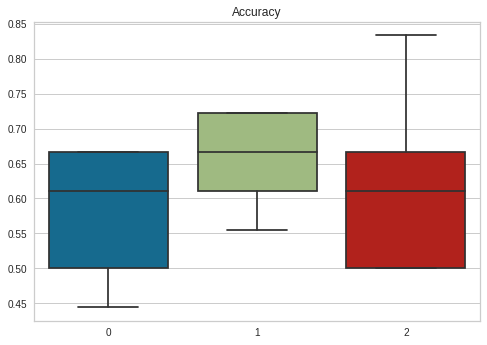

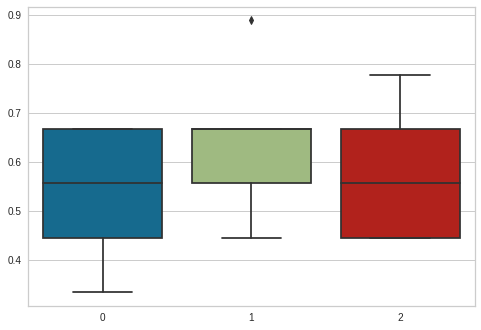

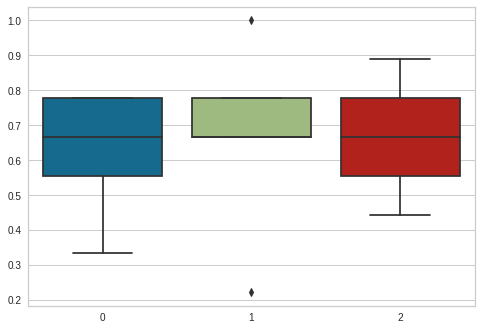

In [58]:
def svm_classifier(C, kernel, degree, gamma, data_train, data_test, label_train, label_test):
    """
    Function for SVM training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        svm_kernel = different kernels to be used (type = string)

    Output is two lists with the predicted class of the train- and testdata
    """
    svc = svm.SVC(C=C, kernel=kernel, degree=degree, gamma=gamma)
    svc.fit(data_train, label_train)

    # Predict the classes of the data 
    label_train_svm = svc.predict(data_train)
    label_test_svm= svc.predict(data_test)

    score_train = svc.score(data_train, label_train)
    score_test = svc.score(data_test, label_test)
    
    return score_train, score_test, label_train_svm, label_test_svm

#KERNELS 
kernels = ['linear', 'poly', 'rbf']
gammas = [0.1, 1, 10, 100]
cs = [0.1, 1, 10, 100, 1000]
degrees = [0, 1, 2, 3, 4, 5, 6] # use only for 'poly'

hyperparameters = dict(kernel = kernels, gamma = gammas, C = cs, degree = degrees)
svm_tune = svm.SVC()
clf_tune_svm = model_selection.RandomizedSearchCV(svm_tune, hyperparameters, n_iter = 30, cv=5)

# 10 keer opnieuw train-val   
sss = model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

selectorlasso = SelectFromModel(estimator=Lasso(alpha=0.067, random_state = 42))
selectoruni = SelectPercentile(f_classif, percentile=20)
selectorpca = PCA(n_components = 20)
selectors = [selectorlasso, selectoruni, selectorpca]

score_train_box = []
score_val_box = []
sens_val_box = []
spec_val_box = []

#SVM met verschillende feature selection methods
for selector in selectors: 
    score_train_selector = []
    score_val_selector = [] 
    sens_val_selector = []
    spec_val_selector = []
    auc_val_selector = []
    for train_index, val_index in sss.split(data_train_scaled, stage_train):
        stage_train_k = np.array(stage_train)  

        split_X_train = data_train_scaled.loc[train_index]
        split_y_train = stage_train_k[train_index]
        split_X_val = data_train_scaled.loc[val_index]
        split_y_val = stage_train_k[val_index]
       
       # Fit Feature Selection
        selector.fit(split_X_train, split_y_train)
        split_X_train = selector.transform(split_X_train)
        split_X_val = selector.transform(split_X_val)

        best_model_svm = clf_tune_svm.fit(split_X_train, split_y_train)
        kernel_best = best_model_svm.best_estimator_.get_params()['kernel']
        gamma_best = best_model_svm.best_estimator_.get_params()['gamma']
        c_best = best_model_svm.best_estimator_.get_params()['C']
        degree_best = best_model_svm.best_estimator_.get_params()['degree']
    
        score_train, score_val, label_train, label_val = svm_classifier(c_best, 
                  kernel_best, degree_best, gamma_best, split_X_train, split_X_val, split_y_train, split_y_val)
    
        conf = confusion_matrix(split_y_val, label_val)
        sens_val = conf[0, 0]/(conf[0, 0]+conf[0, 1])
        spec_val = conf[1, 1]/(conf[1, 0]+conf[1, 1])
        auc_val=metrics.roc_auc_score(label_val, split_y_val)

        score_train_selector.append(score_train)
        score_val_selector.append(score_val)   
        sens_val_selector.append(sens_val)
        spec_val_selector.append(spec_val)
        auc_val_selector.append(auc_val)

        mean_train = mean(score_train_selector)
        mean_val = mean(score_val_selector)
        mean_sens = mean(sens_val_selector)
        mean_spec = mean(spec_val_selector)
        mean_auc=mean(auc_val_selector)
    
    score_train_box.append(score_train_selector)
    score_val_box.append(score_val_selector)
    sens_val_box.append(sens_val_selector)
    spec_val_box.append(spec_val_selector)

   
    print(f'The train accuracy of a kNN x classifier with x feature selection: {mean_train}')
    print(f'The validation accuracy of a kNN x classifier with x feature selection: {mean_val}')
    print(f'The AUC of validation data: {mean_auc}')
    print(f'The sensitivity of validation data: {mean_sens}')
    print(f'The specificity of validation data: {mean_spec}')

plt.figure(1)
sns.boxplot(data=score_val_box).set_title('Accuracy')

plt.figure(2)
sns.boxplot(data=sens_val_box)

plt.figure(3)
sns.boxplot(data=spec_val_box)



## Random Forest

In [0]:
def rfc_classifier(n_estimators, max_depth, min_samples_split, min_samples_leaf, 
                   bootstrap, class_weight, data_train, data_test, label_train, 
                   label_test):
    """
    Function for RFC training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    # Create Random Forest Classifier and fit classifier on traindata
    rfc = RandomForestClassifier(n_estimators = n_estimators, max_depth = 
              max_depth, min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf, bootstrap = bootstrap,
             class_weight = class_weight)
    rfc.fit(data_train, label_train)

    # Predict labels for train- and testdata
    label_train_rfc = rfc.predict(data_train)
    label_test_rfc = rfc.predict(data_test)
    
    score_train = rfc.score(data_train, label_train)
    score_test = rfc.score(data_test, label_test)

    return score_train, score_test, label_train_rfc, label_test_rfc

# Hyperparameters optimization
n_estimators = [10, 30, 50, 100, 300]     
max_depth = [5, 10, 15, 20, 30]                
min_samples_split = [2, 7, 10, 12, 20]      
min_samples_leaf = [1, 5, 10, 15, 20]             
bootstrap = [True, False]
class_weight = [{0: 1, 1: 0.001}, {0: 1, 1: 1}, {0: 1, 1: 10}, {0: 1, 1: 100}]


hyperparameters_rfc = dict(n_estimators = n_estimators, max_depth = max_depth,  
              min_samples_split = min_samples_split, 
             min_samples_leaf = min_samples_leaf, bootstrap = bootstrap, 
             class_weight = class_weight)
rfc_tune = RandomForestClassifier()
clf_tune_rfc = model_selection.RandomizedSearchCV(rfc_tune, hyperparameters_rfc, n_iter = 30, cv=5)

# 10 keer opnieuw train-val   
sss = model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

selectorlasso = SelectFromModel(estimator=Lasso(alpha=0.067, random_state = 42))
selectoruni = SelectPercentile(f_classif, percentile=20)
selectorpca = PCA(n_components = 20)
selectors = [selectorlasso, selectoruni, selectorpca]

score_train_box = []
score_val_box = []
sens_val_box = []
spec_val_box = []

# RF met feature selection methods
for selector in selectors: 
    score_train_selector = []
    score_val_selector = [] 
    sens_val_selector = []
    spec_val_selector = []
    auc_val_selector = []
    for train_index, val_index in sss.split(data_train_scaled, stage_train):
        stage_train_k = np.array(stage_train)  
        split_X_train = data_train_scaled.loc[train_index]
        split_y_train = stage_train_k[train_index]
        split_X_val = data_train_scaled.loc[val_index]
        split_y_val = stage_train_k[val_index]
       
       # Fit Feature Selection
        selector.fit(split_X_train, split_y_train)
        split_X_train = selector.transform(split_X_train)
        split_X_val = selector.transform(split_X_val)

        best_model_rfc = clf_tune_rfc.fit(split_X_train, split_y_train)

        n_estimators_best = best_model_rfc.best_estimator_.get_params()['n_estimators']
        max_depth_best = best_model_rfc.best_estimator_.get_params()['max_depth']
        min_samples_split_best = best_model_rfc.best_estimator_.get_params()['min_samples_split']
        min_samples_leaf_best = best_model_rfc.best_estimator_.get_params()['min_samples_leaf']
        bootstrap_best = best_model_rfc.best_estimator_.get_params()['bootstrap']
        class_weight_best = best_model_rfc.best_estimator_.get_params()['class_weight']

        score_train, score_val, label_train_, label_val = rfc_classifier(n_estimators_best, 
                        max_depth_best, min_samples_split_best, min_samples_leaf_best, 
                        bootstrap_best, class_weight_best, split_X_train, split_X_val, 
                        split_y_train, split_y_val)
    
        conf = confusion_matrix(split_y_val, label_val)
        sens_val = conf[0, 0]/(conf[0, 0]+conf[0, 1])
        spec_val = conf[1, 1]/(conf[1, 0]+conf[1, 1])
        
        auc_val=metrics.roc_auc_score(label_val, split_y_val)

        score_train_selector.append(score_train)
        score_val_selector.append(score_val)   
        sens_val_selector.append(sens_val)
        spec_val_selector.append(spec_val)
        auc_val_selector.append(auc_val)

        mean_train = mean(score_train_selector)
        mean_val = mean(score_val_selector)
        mean_sens = mean(sens_val_selector)
        mean_spec = mean(spec_val_selector)
        mean_auc=mean(auc_val_selector)
    
    score_train_box.append(score_train_selector)
    score_val_box.append(score_val_selector)
    sens_val_box.append(sens_val_selector)
    spec_val_box.append(spec_val_selector)

   
    print(f'The train accuracy of a kNN x classifier with x feature selection: {mean_train}')
    print(f'The validation accuracy of a kNN x classifier with x feature selection: {mean_val}')
    print(f'The AUC of validation data: {mean_auc}')
    print(f'The sensitivity of validation data: {mean_sens}')
    print(f'The specificity of validation data: {mean_spec}')

plt.figure(1)
sns.boxplot(data=score_val_box).set_title('Accuracy')

plt.figure(2)
sns.boxplot(data=sens_val_box)

plt.figure(3)
sns.boxplot(data=spec_val_box)


The train accuracy of a kNN x classifier with x feature selection: 0.8361111111111111
The validation accuracy of a kNN x classifier with x feature selection: 0.6777777777777778
The AUC of validation data: 0.6982267732267732
The sensitivity of validation data: 0.6222222222222222
The specificity of validation data: 0.7333333333333333


ValueError: ignored

## Neural network


*   Classifier obv neural network
*   Met cross validatie selectie van de juiste hyperparameters: hidden_layer_sizes, activation, solver, alpha, learning_rate, batch_size. Eventueel tunen op nog meer hyperparameters?
*   Getuned mbv randomized search


## stond nog erin, weet niet of het weg moet
neural_network = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15,), random_state=1)

neural_network.fit(data_train_l1, stage_train)

score_train_neural_network = neural_network.score(data_train_l1, stage_train)

score_test_neural_network = neural_network.score(data_test_l1, stage_test)



In [0]:
def neural_network_classifier(hidden_layer_sizes, activation, solver, alpha, learning_rate, 
                              batch_size, data_train, data_test, label_train, label_test):
    """
    Function for neural network training and testing

        data_train =  training data (type = list)
        data_test_trans = testing data (type = list)
        label_train = class of training data (type = list)
        label_test = class of testing data (type = list)
        
    Output is two lists with the predicted class of the train- and testdata 
    """
    # Create neural network Classifier and fit classifier on traindata
    neural_network = MLPClassifier(hidden_layer_sizes = hidden_layer_sizes, activation = 
              activation, solver = solver, 
             alpha = alpha, learning_rate = learning_rate,
             batch_size = batch_size)
    neural_network.fit(data_train, label_train)

    # Scores and predicted labels of neural network classifier
    label_train_neural_network = neural_network.predict(data_train)
    label_test_neural_network = neural_network.predict(data_test)
    
    score_train_neural_network = neural_network.score(data_train, label_train)
    score_test_neural_network = neural_network.score(data_test, label_test)

    return score_train_neural_network, score_test_neural_network, label_train_neural_network, label_test_neural_network

# Hyperparameters optimization

hyperparameters_neural_network = {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
                                  'activation': ['tanh', 'relu','identity', 'logistic'], 
                                  'solver': ['lbfgs', 'sgd', 'adam'],
                                  'alpha':[0.0001, 0.005, 0.05],
                                  'learning_rate':['constant', 'adaptive'],
                                  'batch_size':[5, 10, 15, 20, 25]}
neural_network_tune = MLPClassifier()
clf_tune_neural_network = model_selection.RandomizedSearchCV(neural_network_tune, 
                                      hyperparameters_neural_network, n_iter = 30, cv=5)

# For loop for calculation
score_train_nn = []
score_test_nn = []
stage_train_nn = []
stage_test_nn = []

for df, df_test in zip(data_train_fs, data_test_fs):
    best_model_neural_network = clf_tune_neural_network.fit(df, stage_train)

    hidden_layer_sizes_best = best_model_neural_network.best_estimator_.get_params()['hidden_layer_sizes']
    activation_best = best_model_neural_network.best_estimator_.get_params()['activation']
    solver_best = best_model_neural_network.best_estimator_.get_params()['solver']
    alpha_best = best_model_neural_network.best_estimator_.get_params()['alpha']
    learning_rate_best = best_model_neural_network.best_estimator_.get_params()['learning_rate']
    batch_size_best = best_model_neural_network.best_estimator_.get_params()['batch_size']
    
    score_train_n, score_test_n, stage_train_n, stage_test_n = neural_network_classifier(
                     hidden_layer_sizes_best, activation_best, solver_best, alpha_best, 
                     learning_rate_best, batch_size_best, df, df_test, 
                     stage_train, stage_test)

    score_train_nn.append(score_train_n)
    score_test_nn.append(score_test_n)
    stage_train_nn.append(stage_train_n)
    stage_test_nn.append(stage_test_n)


# Printing accuracy and predicted stage
print(f'Accuracy of neural network classifier on traindata: {score_train_nn}') # accuracy
print(f'Accuracy of neural network classifier on testdata: {score_test_nn}') # accuracy
print(stage_train_nn)
print(' ')
print(stage_test_nn)

## Putting it all together
- First: splitting start_data (hn dataframe) into a dataframe with features and one with stages

- Defining some functions we will later use
- Some functions were already defined in the exploration fase


In [0]:
stage = data_start['label']
data = data_start.drop(columns='label')
stage = preprocessing.label_binarize(stage, ['T12', 'T34'] )
stage = [i[0] for i in stage]

pd.options.mode.chained_assignment = None  

# PCA function

In [0]:
def pca_opt(data_train, data_test):
    """
    Function for PCA

        data_train = training data
        data_test = testing data

    Output is transformed train- and testdata
    """
    pca=PCA().fit(data_train)

    # Amount of n-components based on a variance level of 0.99
    var = np.cumsum(pca.explained_variance_ratio_)
    n_comp = np.where(var>0.99)[0][0]

    pca_train = PCA(n_components=n_comp)
    pca_train.fit(data_train)

    # Transform data using PCA
    data_train = pca_train.transform(data_train)
    data_test = pca_train.transform(data_test)

    # Return transformed train- and testdata
    return data_train, data_test

## kNN Optimization function

In [0]:
def knn_class(data_train, data_test, stage_train, stage_test):
    """
    Function for optimalizing the hyperparameters:
      - n_neighbours
      - weights
    in a kNN classifier.
    Output is:
      - knn: a classifier with optimized hyperparameters
      - acc_train: the accuracy of the optimized classifier on the trainig data
      - acc_test: the accuracy of the optimized classifier on the testing data
      - auc_test: the area under the curve of the optimized classifier on the testing data
    """
    
    # Hyperparameters optimization 
    n_n = list(range(1,50))
    weights = ['uniform', 'distance']

    hyperparameters = dict(n_neighbors=n_n, weights = weights)
    knn_tune = neighbors.KNeighborsClassifier()
    clf_tune_knn = model_selection.RandomizedSearchCV(knn_tune, hyperparameters, n_iter = 30, cv=5)

    best_model = clf_tune_knn.fit(data_train, stage_train)
    n_n_best = best_model.best_estimator_.get_params()['n_neighbors']
    weights_best = best_model.best_estimator_.get_params()['weights']

    knn = neighbors.KNeighborsClassifier(n_neighbors = n_n_best, weights = weights_best)
    knn.fit(data_train, stage_train)
    label_train_knn = knn.predict(data_train)
    label_test_knn = knn.predict(data_test)
    
    acc_train = knn.score(data_train, stage_train)
    acc_test = knn.score(data_test, stage_test)
    auc_test = metrics.roc_auc_score(label_test_knn, stage_test)
        
    return knn, acc_train, acc_test, auc_test

## SVM Optimization Function

In [0]:
def svm_class(data_train, data_test, stage_train, stage_test):
    """
    Function for optimalizing the hyperparameters:
      - kernel
      - gamma
      - C
      - degree
    in a SVM classifier.
    Output is:
      - svc: a classifier with optimized hyperparameters
      - acc_train: the accuracy of the optimized classifier on the trainig data
      - acc_test: the accuracy of the optimized classifier on the testing data
      - auc_test: the area under the curve of the optimized classifier on the testing data
     """
    # Hyperparameter optimization
    kernels = ['linear', 'poly', 'rbf']
    gammas = [0.1, 1, 10, 100]
    cs = [0.1, 1, 10, 100, 1000]
    degrees = [0, 1, 2, 3, 4, 5, 6] # use only for 'poly'

    hyperparameters = dict(kernel = kernels, gamma = gammas, C = cs, degree = degrees)
    svm_tune = svm.SVC()
    clf_tune_svm = model_selection.RandomizedSearchCV(svm_tune, hyperparameters, n_iter = 30, cv = 5)

    best_model_svm = clf_tune_svm.fit(data_train,stage_train)
    kernel_best = best_model_svm.best_estimator_.get_params()['kernel']
    gamma_best  = best_model_svm.best_estimator_.get_params()['gamma']
    C_best = best_model_svm.best_estimator_.get_params()['C']
    degree_best = best_model_svm.best_estimator_.get_params()['degree']

    svc = svm.SVC(C=C_best, kernel=kernel_best, degree=degree_best, gamma=gamma_best)
    svc.fit(data_train, stage_train)

    # Predict the classes of the data 
    label_train_svm = svc.predict(data_train)
    label_test_svm= svc.predict(data_test)

    acc_train = svc.score(data_train, stage_train)
    acc_test = svc.score(data_test, stage_test)
    auc_test = metrics.roc_auc_score(label_test_svm, stage_test)
    
    return svc, acc_train, acc_test,  auc_test

## RF Optimization Function

In [0]:
def rf_class(data_train, data_test, stage_train, stage_test):
    """
    Function for optimalizing the hyperparameters:
      - n_neighbours
      - weights
    in a Random Forest classifier.
    Output is:
      - rfc: a classifier with optimized hyperparameters
      - acc_train: the accuracy of the optimized classifier on the trainig data
      - acc_test: the accuracy of the optimized classifier on the testing data
      - auc_test: the area under the curve of the optimized classifier on the testing data
    """

    # Hyperparameters optimization 
    n_estimators = [10, 30, 50, 100, 300]                  
    min_samples_split = [2, 7, 10, 12, 20]      
    min_samples_leaf = [3, 5, 10, 15, 20]             

    hyperparameters_rfc = dict(n_estimators=n_estimators, min_samples_split = min_samples_split, min_samples_leaf = min_samples_leaf)
    rfc_tune = RandomForestClassifier()
    clf_tune_rfc = model_selection.RandomizedSearchCV(rfc_tune, hyperparameters_rfc, n_iter = 30, cv=5)

    best_model = clf_tune_rfc.fit(data_train, stage_train)
    n_estimators_best = best_model.best_estimator_.get_params()['n_estimators']
    min_samples_split_best = best_model.best_estimator_.get_params()['min_samples_split']
    min_samples_leaf_best = best_model.best_estimator_.get_params()['min_samples_leaf']

    rfc = RandomForestClassifier(n_estimators=n_estimators_best, min_samples_split = min_samples_split_best, min_samples_leaf = min_samples_leaf_best)
    rfc.fit(data_train, stage_train)
    label_train_rfc = rfc.predict(data_train)
    label_test_rfc = rfc.predict(data_test)
    
    acc_train = rfc.score(data_train, stage_train)
    acc_test = rfc.score(data_test, stage_test)
    auc_test = metrics.roc_auc_score(label_test_rfc, stage_test)
        
    return rfc, acc_train, acc_test, auc_test

## Cross validation Univariate Feature selection
- Calculate mean accuracy and mean area under the curve (on test data) in a cross-validation

In [64]:
# Define cross validation for outer cross-validation
cv10_fold = model_selection.StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)

# Create empty lists to store the performance of the classifiers
acc_knn = []
acc_svm = []
auc_knn = []
auc_svm = []
acc_rf = []
auc_rf = []

# Outer cross-valdation
for train_index, test_index in cv10_fold.split(data, stage):
    
    # split data in features- and stage
    stage = np.array(stage)
    outer_train = data.iloc[train_index]
    outer_stage_train = stage[train_index]
    outer_test = data.iloc[test_index]
    outer_stage_test = stage[test_index]

    # Remove columns from dataframes
    outer_train, outer_test = data_cleaning(outer_train, outer_test)
        
    # Data scaling
    outer_train, outer_test = data_scaling(outer_train, outer_test)

    # Feature selection (based on cv)
    outer_train, outer_test = uni_features(outer_train, outer_test, outer_stage_train)

    # kNN Optimization
    clf_knn, acc_train, acc_test, auc_test = knn_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    acc_knn.append(acc_test)
    auc_knn.append(auc_test)

    # SVM Optimization
    clf_svm, acc_train, acc_test, auc_test = svm_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    acc_svm.append(acc_test)
    auc_svm.append(auc_test)

    # RF Optimization
    clf_rf, acc_train, acc_test, auc_test = svm_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    acc_rf.append(acc_test)
    auc_rf.append(auc_test)

print(f'The mean accuracy of the kNN-classifier: {mean(acc_knn)}')
print(f'The mean AUC of the kNN-classifier: {mean(auc_knn)}')
print(f'The mean accuracy of the SVM-classifier: {mean(acc_svm)}')
print(f'The mean AUC of the SVM-classifier: {mean(auc_svm)}')
print(f'The mean accuracy of the RF-classifier: {mean(acc_rf)}')
print(f'The mean AUC of the RF-classifier: {mean(auc_rf)}')

The mean accuracy of the kNN-classifier: 0.658695652173913
The mean AUC of the kNN-classifier: 0.6648211857586858
The mean accuracy of the SVM-classifier: 0.65
The mean AUC of the SVM-classifier: 0.6553661616161616
The mean accuracy of the RF-classifier: 0.6369565217391304
The mean AUC of the RF-classifier: 0.642457264957265


## Cross validation Prinicple Component Analysis
- Calculate mean accuracy and mean area under the curve (on test data) in a cross-validation

In [65]:
# Define cross validation for outer cross-validation
cv10_fold = model_selection.StratifiedShuffleSplit(n_splits=20, test_size=0.2, random_state=42)

# Create empty lists to store the performance of the classifiers
acc_knn = []
acc_svm = []
auc_knn = []
auc_svm = []
acc_rf = []
auc_rf = []

# Outer Cross-Validation
for train_index, test_index in cv10_fold.split(data, stage):
    
    stage = np.array(stage)
    outer_train = data.iloc[train_index]
    outer_stage_train = stage[train_index]
    outer_test = data.iloc[test_index]
    outer_stage_test = stage[test_index]

    # Remove columns from dataframes
    outer_train, outer_test = data_cleaning(outer_train, outer_test)
        
    # Data scaling
    outer_train, outer_test = data_scaling(outer_train, outer_test)

    # Feature PCA
    outer_train, outer_test = pca_opt(outer_train, outer_test)

    # kNN Optimization
    clf_knn, acc_train, acc_test, auc_test = knn_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    acc_knn.append(acc_test)
    auc_knn.append(auc_test)

    # SVM Optimization
    clf_svm, acc_train, acc_test, auc_test = svm_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    acc_svm.append(acc_test)
    auc_svm.append(auc_test)

    # RF Optimization
    clf_rf, acc_train, acc_test, auc_test = svm_class(outer_train, outer_test, outer_stage_train, outer_stage_test)
    acc_rf.append(acc_test)
    auc_rf.append(auc_test)

print(f'The mean accuracy of the kNN-classifier: {mean(acc_knn)}')
print(f'The mean AUC of the kNN-classifier: {mean(auc_knn)}')
print(f'The mean accuracy of the SVM-classifier: {mean(acc_svm)}')
print(f'The mean AUC of the SVM-classifier: {mean(auc_svm)}')
print(f'The mean accuracy of the RF-classifier: {mean(acc_rf)}')
print(f'The mean AUC of the RF-classifier: {mean(auc_rf)}')


The mean accuracy of the kNN-classifier: 0.6543478260869565
The mean AUC of the kNN-classifier: 0.6954281237553297
The mean accuracy of the SVM-classifier: 0.6565217391304348
The mean AUC of the SVM-classifier: 0.667808333414951
The mean accuracy of the RF-classifier: 0.6391304347826087
The mean AUC of the RF-classifier: 0.6502483239799417


# 3 Loops
- choose best model for each inner cross validation
- compare models, choose one with highest performance
- fit chosen model on outer loop



In [66]:
# splitting in train- and test
cv10_fold = model_selection.StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)
cv5_fold = model_selection.StratifiedKFold(n_splits=10)

acc_total_knn = []
auc_total_knn = []
acc_total_svm = []
auc_total_svm = []

for train_index, test_index in cv10_fold.split(data, stage):
    stage = np.array(stage)
    outer_train = data.iloc[train_index]
    outer_stage_train = stage[train_index]
    outer_test = data.iloc[test_index]
    outer_stage_test = stage[test_index]

    classifier_knn = []
    acc_train_knn = []
    acc_val_knn = []
    auc_val_knn = []
    classifier_rf = []
    acc_train_rf = []
    acc_val_rf = []
    auc_val_rf = []
    classifier_svm = []
    acc_train_svm = []
    acc_val_svm = []
    auc_val_svm = []
    classifier_nn = []
    acc_train_nn = []
    acc_val_nn = []
    auc_val_nn = []

    for train_index, val_index in cv5_fold.split(outer_train, outer_stage_train):
        
        inner_train = outer_train.iloc[train_index] 
        inner_stage_train = outer_stage_train[train_index]
        inner_val = outer_train.iloc[val_index]
        inner_stage_val = outer_stage_train[val_index]
        
        # Remove columns from dataframes
        inner_train, inner_val = data_cleaning(inner_train, inner_val)
        
        # Data scaling
        inner_train, inner_val = data_scaling(inner_train, inner_val)

        # Univariate Feature Selection
        inner_train, inner_val = uni_features(inner_train, inner_val, inner_stage_train)

        # kNN Optimization
        clf_knn, acc_train, acc_val, auc_val = knn_class(inner_train, inner_val, inner_stage_train, inner_stage_val)
        classifier_knn.append(clf_knn)
        acc_val_knn.append(acc_val)
        max_value_knn = max(acc_val_knn)
        max_index_knn = acc_val_knn.index(max_value_knn)
        max_clf_knn = classifier_knn[max_index_knn]

        # SVM Optimization
        clf_svm, acc_train, acc_val, auc_val = svm_class(inner_train, inner_val, inner_stage_train, inner_stage_val)
        classifier_svm.append(clf_knn)
        acc_val_svm.append(acc_val)
        max_value_svm = max(acc_val_svm)
        max_index_svm = acc_val_svm.index(max_value_svm)
        max_clf_svm = classifier_svm[max_index_svm]
           
        # RF Optimization
        #clf_rf, acc_train, acc_val, auc_val = rf_classifier(inner_train, inner_val, inner_stage_train, inner_stage_val)
        #classifier_rf.append(clf_knn)
        #acc_val_rf.append(acc_val)
        #max_value_rf = max(acc_val_rf)
        #max_index_rf = acc_val_rf.index(max_value_rf)
        #max_clf_rf = classifier_rf[max_index_rf]

    # Remove columns from dataframes
    outer_train, outer_test = data_cleaning(outer_train, outer_test)
        
    # Data scaling
    outer_train, outer_test = data_scaling(outer_train, outer_test)

    # Univariate Feature Selection
    outer_train, outer_test = uni_features(outer_train, outer_test, outer_stage_train)
    
    max_clf_knn.fit(outer_train, outer_stage_train)
    predict_test_knn = max_clf_knn.predict(outer_test)
    auc_knn = metrics.roc_auc_score(predict_test_knn, outer_stage_test)
    acc_knn = max_clf_knn.score(outer_test, outer_stage_test)
    acc_total_knn.append(acc_knn)
    auc_total_knn.append(auc_knn)    

    max_clf_svm.fit(outer_train, outer_stage_train)
    predict_test_knn = max_clf_knn.predict(outer_test)
    auc_svm = metrics.roc_auc_score(predict_test_knn, outer_stage_test)
    acc_svm = max_clf_knn.score(outer_test, outer_stage_test)
    acc_total_svm.append(acc_knn)
    auc_total_svm.append(auc_knn) 

print(f'The mean accuracy of a knn-classifier is: {mean(acc_total_knn)}')  
print(f'The mean accuracy of a knn-classifier is: {mean(auc_total_knn)}')   
print(f'The mean accuracy of a svm-classifier is: {mean(acc_total_svm)}')   
print(f'The mean accuracy of a svm-classifier is: {mean(auc_total_svm)}')    
    

The mean accuracy of a knn-classifier is: 0.6782608695652174
The mean accuracy of a knn-classifier is: 0.6860027472527472
The mean accuracy of a svm-classifier is: 0.6782608695652174
The mean accuracy of a svm-classifier is: 0.6860027472527472
